In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import gc

# Prepare data

In [2]:
test = pd.read_csv('../data/test.csv')

In [27]:
submit = pd.read_csv('../data/sample_submission.csv')

In [3]:
test.loc[:, 'click_datetime'] = pd.to_datetime(test.click_time, format='%Y-%m-%d %H:%M:%S')
test.loc[:, 'date'] = test.click_datetime.dt.date
test.loc[:, 'minute'] = test.click_datetime.dt.hour * 60 + test.click_datetime.dt.minute

In [5]:
test.drop(['click_time', 'click_datetime'], axis=1, inplace=True)

In [6]:
gc.collect()

7906

In [11]:
test_gp_idm = test.groupby(['ip', 'date', 'minute'])

In [7]:
def get_sum(group_obj, col):
    res = group_obj[col].nunique()
    res.name = col + 's'
    return res

In [8]:
def get_entropy(group_obj, col):
    values = group_obj[col].value_counts(normalize=True)
    values_log = pd.Series(np.log(values), index=values.index)
    entropy_prep = - values * values_log
    entropy = entropy_prep.groupby(level=[0, 1, 2]).sum()
    entropy.name = col + '_ent'
    return entropy

In [9]:
def create_feats(group_obj, feats=['app', 'device', 'os', 'channel']):
    print('clicks ...')
    clicks = group_obj.size()
    clicks.name = 'clicks'
    print('others ...')
    series = [clicks]
    for feat in feats:
        series.append(get_sum(group_obj, feat))
        series.append(get_entropy(group_obj, feat))
    return pd.concat(series, axis=1)

In [12]:
test_feats = create_feats(test_gp_idm)

clicks ...
others ...


In [16]:
test_feats.head()

clicks  apps   app_ent  devices  device_ent  oss  \
ip date       minute                                                     
0  2017-11-10 291          1     1  0.000000        1         0.0    1   
              294          1     1  0.000000        1         0.0    1   
1  2017-11-10 294          1     1  0.000000        1         0.0    1   
2  2017-11-10 637          1     1  0.000000        1         0.0    1   
              783          4     4  1.386294        1         0.0    1   

                      os_ent  channels  channel_ent  
ip date       minute                                 
0  2017-11-10 291        0.0         1     0.000000  
              294        0.0         1     0.000000  
1  2017-11-10 294        0.0         1     0.000000  
2  2017-11-10 637        0.0         1     0.000000  
              783        0.0         3     1.039721

In [13]:
test = pd.merge(test, test_feats, left_on=['ip', 'date', 'minute'], right_index=True, how='left')

In [14]:
test.isnull().sum()

click_id       0
ip             0
app            0
device         0
os             0
channel        0
date           0
minute         0
clicks         0
apps           0
app_ent        0
devices        0
device_ent     0
oss            0
os_ent         0
channels       0
channel_ent    0
dtype: int64

In [15]:
test.head()

,click_id,ip,app,device,os,channel,date,minute,clicks,apps,app_ent,devices,device_ent,oss,os_ent,channels,channel_ent
0,0,5744,9,1,3,107,2017-11-10,240,2,2,0.693147,1,0.0,1,0.000000,2,0.693147
1,1,119901,9,1,3,466,2017-11-10,240,15,8,1.771624,1,0.0,3,0.853236,9,2.048883
2,2,72287,21,1,19,128,2017-11-10,240,5,4,1.332179,1,0.0,4,1.332179,5,1.609438
3,3,78477,15,1,13,111,2017-11-10,240,9,6,1.676988,1,0.0,2,0.348832,8,2.043192
4,4,123080,12,1,13,328,2017-11-10,240,4,4,1.386294,1,0.0,1,0.000000,4,1.386294


In [16]:
test.to_csv('../derived_data/aggregated_clicks_test.csv', index=False)

# Random forest

In [2]:
import pickle

In [10]:
read_cols = ['click_id', 'app', 'device', 'os', 'channel', 'minute', 'clicks', 'apps', 'app_ent',
             'devices', 'device_ent', 'oss', 'os_ent', 'channels', 'channel_ent']

In [11]:
test = pd.read_csv('../derived_data/aggregated_clicks_test.csv', usecols=read_cols)

In [12]:
test.head()

,click_id,app,device,os,channel,minute,clicks,apps,app_ent,devices,device_ent,oss,os_ent,channels,channel_ent
0,0,9,1,3,107,240,2,2,0.693147,1,0.0,1,0.000000,2,0.693147
1,1,9,1,3,466,240,15,8,1.771624,1,0.0,3,0.853236,9,2.048883
2,2,21,1,19,128,240,5,4,1.332179,1,0.0,4,1.332179,5,1.609438
3,3,15,1,13,111,240,9,6,1.676988,1,0.0,2,0.348832,8,2.043192
4,4,12,1,13,328,240,4,4,1.386294,1,0.0,1,0.000000,4,1.386294


In [16]:
test.shape

(18790469, 15)

In [13]:
test = test.reindex(columns=read_cols)

In [14]:
test.head()

,click_id,app,device,os,channel,minute,clicks,apps,app_ent,devices,device_ent,oss,os_ent,channels,channel_ent
0,0,9,1,3,107,240,2,2,0.693147,1,0.0,1,0.000000,2,0.693147
1,1,9,1,3,466,240,15,8,1.771624,1,0.0,3,0.853236,9,2.048883
2,2,21,1,19,128,240,5,4,1.332179,1,0.0,4,1.332179,5,1.609438
3,3,15,1,13,111,240,9,6,1.676988,1,0.0,2,0.348832,8,2.043192
4,4,12,1,13,328,240,4,4,1.386294,1,0.0,1,0.000000,4,1.386294


In [5]:
with open('../derived_data/random_forest_aggregated_clicks.pk', 'rb') as f:
    rfc = pickle.load(f)

In [20]:
test.isnull().sum()

click_id              0
app                   0
device                0
os                    0
channel               0
minute                0
clicks                0
apps                  0
app_ent               0
devices               0
device_ent            0
oss                   0
os_ent                0
channels              0
channel_ent           0
prob           18790469
dtype: int64

In [21]:
test.drop('prob', axis=1, inplace=True)

In [22]:
prob = rfc.predict_proba(test.iloc[:, 1:])

In [23]:
test.loc[:, 'prob'] = prob[:, 1]

In [24]:
test.head()

,click_id,app,device,os,channel,minute,clicks,apps,app_ent,devices,device_ent,oss,os_ent,channels,channel_ent,prob
0,0,9,1,3,107,240,2,2,0.693147,1,0.0,1,0.000000,2,0.693147,0.0
1,1,9,1,3,466,240,15,8,1.771624,1,0.0,3,0.853236,9,2.048883,0.0
2,2,21,1,19,128,240,5,4,1.332179,1,0.0,4,1.332179,5,1.609438,0.0
3,3,15,1,13,111,240,9,6,1.676988,1,0.0,2,0.348832,8,2.043192,0.0
4,4,12,1,13,328,240,4,4,1.386294,1,0.0,1,0.000000,4,1.386294,0.0


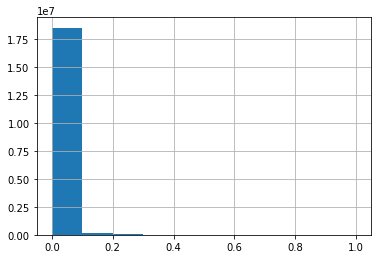

In [25]:
test.prob.hist()

In [26]:
test.prob.max()

1.0

In [28]:
submit.head()

,click_id,is_attributed
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [30]:
submit.sort_values('click_id', inplace=True)

In [31]:
test.sort_values('click_id', inplace=True)

In [32]:
submit.loc[:, 'is_attributed'] = test.prob

In [33]:
submit.head()

,click_id,is_attributed
0,0,0.0
1,1,0.0
2,2,0.0
3,3,0.0
4,4,0.0


In [34]:
submit.isnull().sum()

click_id         0
is_attributed    0
dtype: int64

In [35]:
submit.to_csv('../results/random_forest_aggregated_clicks.csv', index=False)